In [1]:
import pandas as pd

file_path = "./PS1_template.xlsx"
df = pd.read_excel(file_path, sheet_name="WRDS clean")
df.head()


,secid,date,symbol,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,optionid,ticker,index_flag,issuer,exercise_style
0,108105,2023-01-09,SPX 230317P1800000,2023-03-17,P,1800000,0.30,0.45,7000,11353,144072517,SPX,1,CBOE S&P 500 INDEX,E
1,108105,2023-01-09,SPX 230317P2000000,2023-03-17,P,2000000,0.55,0.65,256,43053,144072520,SPX,1,CBOE S&P 500 INDEX,E
2,108105,2023-01-09,SPX 230317P2200000,2023-03-17,P,2200000,0.90,1.05,94,15866,144072522,SPX,1,CBOE S&P 500 INDEX,E
3,108105,2023-01-09,SPX 230317P2300000,2023-03-17,P,2300000,1.20,1.30,280,15535,144072523,SPX,1,CBOE S&P 500 INDEX,E
4,108105,2023-01-09,SPX 230317P2400000,2023-03-17,P,2400000,1.50,1.60,3234,18576,144072524,SPX,1,CBOE S&P 500 INDEX,E


In [2]:
risk_free = 0.043303546
dividend = 0.01010426  
S0 = 3892.09

df["SpotPrice"] = S0
df["RiskFree"] = risk_free
df["Dividend"] = dividend
df["TimeToMaturity"] = (pd.to_datetime("2023-03-17") - pd.to_datetime("2023-01-09")).days / 365
df["MarketPrice"] = (df["best_bid"] + df["best_offer"]) / 2
df["Strike"] = df["strike_price"]/1000

# Task a

In [3]:
import numpy as np
import scipy.optimize as opt
from scipy.stats import norm


def black_scholes_price(K, S0, sigma, q, r, T, option_type):
    d1 = (np.log(S0 / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == "C":
        price = S0 * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:  # Put
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S0 * np.exp(-q * T) * norm.cdf(-d1)
    return price

sigma_fixed = 0.1
df["BS_Price"] = [black_scholes_price(k, S0, sigma_fixed, q, r, T, option_type) 
                  for k, option_type, r, q, T in zip(df["Strike"], df["cp_flag"], df["RiskFree"], df["Dividend"], df["TimeToMaturity"])]


In [4]:
df["BS_Price"].describe()

count    1.690000e+02
mean     1.132062e+01
std      1.807777e+01
min      4.637453e-73
25%      1.711319e-02
50%      1.613824e+00
75%      1.412444e+01
max      7.443743e+01
Name: BS_Price, dtype: float64

# Task b

In [5]:
# Implied Volatility Calculation
def implied_volatility(market_price, K, S0, d, r, T, option_type):
    def objective(sigma):
        return black_scholes_price(K, S0, sigma, d, r, T, option_type) - market_price
    
    try:
        return opt.brentq(objective, 1e-6, 2.0)  
    except ValueError:
        return np.nan  

df["ImpliedVol"] = [implied_volatility(v, k, S0, d, r, T, t) 
                    for v, k, t, r, d, T in zip(df["MarketPrice"], df["Strike"], df["cp_flag"], df["RiskFree"], df["Dividend"], df["TimeToMaturity"])]
df["ImpliedVol"]



0      0.624896
1      0.569693
2      0.519630
3      0.496170
4      0.471492
         ...   
164    0.173274
165    0.177195
166    0.178697
167    0.183518
168    0.208014
Name: ImpliedVol, Length: 169, dtype: float64

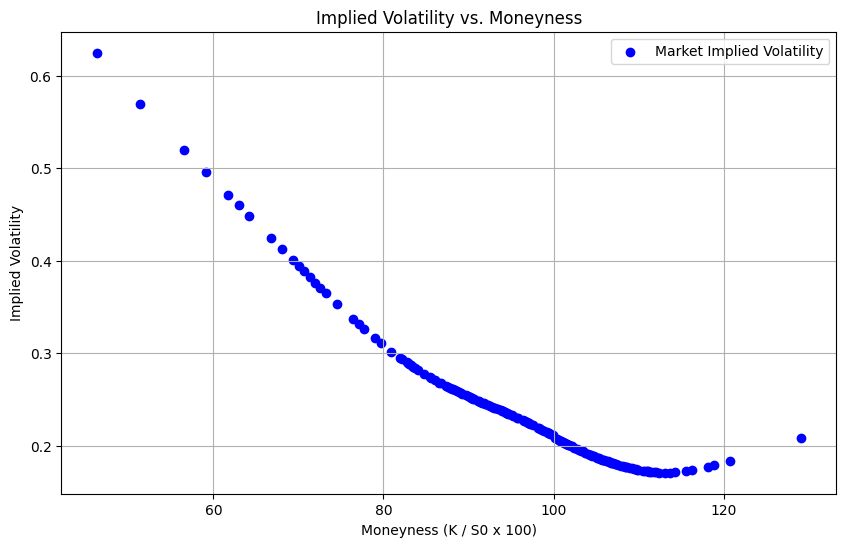

In [6]:
import matplotlib.pyplot as plt

# 绘制隐含波动率 vs. moneyness 曲线
plt.figure(figsize=(10, 6))
plt.scatter(df["Strike"] / S0 * 100, df["ImpliedVol"], label="Market Implied Volatility", color="blue")
plt.xlabel("Moneyness (K / S0 x 100)")
plt.ylabel("Implied Volatility")
plt.legend()
plt.title("Implied Volatility vs. Moneyness")
plt.grid()
plt.show()


# Task c

In [7]:
from scipy.optimize import curve_fit

def black_scholes_wrapper(K, sigma_M):
    return np.array([
        black_scholes_price(k, S0, sigma_M, d, r, T, option_type)
        for k, d, r, T, option_type in zip(
            df["Strike"], df["Dividend"], df["RiskFree"], df["TimeToMaturity"], df["cp_flag"]
        )
    ])

popt, _ = curve_fit(black_scholes_wrapper, df["Strike"], df["MarketPrice"], p0=[0.1], bounds=(0.01, 2))
sigma_M = popt[0]
sigma_M

0.2068553218257582

# Task d

In [13]:
def mixed_lognormal_price(K, S0, r, d, T, p, F1, sigma1, sigma2, option_type):
    F = S0 * np.exp((r - d) * T)

    def bs_price_mixed(K, F, sigma, q, r, T, option_type):
        d1 = (np.log(F / K) + 0.5 * sigma ** 2 * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        
        if option_type == "C":
            price = np.exp(-r * T) *(F * norm.cdf(d1) - K * norm.cdf(d2))
        else:  # Put
            price = np.exp(-r * T) * (K * norm.cdf(-d2) - F * norm.cdf(-d1))
        return price
    
    F2 = (F - p * F1) / (1 - p) 
    C1 = bs_price_mixed(K, F1, sigma1, d, r, T, option_type)
    C2 = bs_price_mixed(K, F2, sigma2, d, r, T, option_type)
    return p * C1 + (1 - p) * C2

def objective_mixed(params):
    p, F1, sigma1, sigma2 = params
    
    errors = np.array([
        mixed_lognormal_price(k, S0, r, d, T, p, F1, sigma1, sigma2, t) - v
        for k, v, t, r, d, T in zip(df["Strike"], df["MarketPrice"], df["cp_flag"], df["RiskFree"], df["Dividend"], df["TimeToMaturity"])
    ])
    return np.sum(errors ** 2)


initial_guess = [0.5, S0, 0.2, 0.3]

bounds = [(0.01, 0.99), (S0 * 0.5, S0 * 1.5), (0.01, 2), (0.01, 2)]

result_mixed = opt.minimize(objective_mixed, initial_guess, bounds=bounds, method="L-BFGS-B")
p_opt, F1_opt, sigma1_opt, sigma2_opt = result_mixed.x

df["MixedLognormal_Price"] = [mixed_lognormal_price(k, S0, r, d, T, p_opt, F1_opt, sigma1_opt, sigma2_opt, t) 
                              for k, t, r, d, T in zip(df["Strike"], df["cp_flag"], df["RiskFree"], df["Dividend"], df["TimeToMaturity"])]

df["MixedLognormal_ImpliedVol"] = [implied_volatility(v, k, S0, d, r, T, t) 
                                   for v, k, t, r, d, T in zip(df["MixedLognormal_Price"], df["Strike"], df["cp_flag"], df["RiskFree"], df["Dividend"], df["TimeToMaturity"])]

# 显示优化后的参数
optimal_params = {
    "p": p_opt,
    "F1": F1_opt,
    "sigma1": sigma1_opt,
    "sigma2": sigma2_opt
}

optimal_params


C:\Users\12194\AppData\Local\Temp\ipykernel_69856\2948746760.py:5: RuntimeWarning: invalid value encountered in log
  d1 = (np.log(F / K) + 0.5 * sigma ** 2 * T) / (sigma * np.sqrt(T))


{'p': 0.5, 'F1': 3892.09, 'sigma1': 0.2, 'sigma2': 0.3}

# Task e

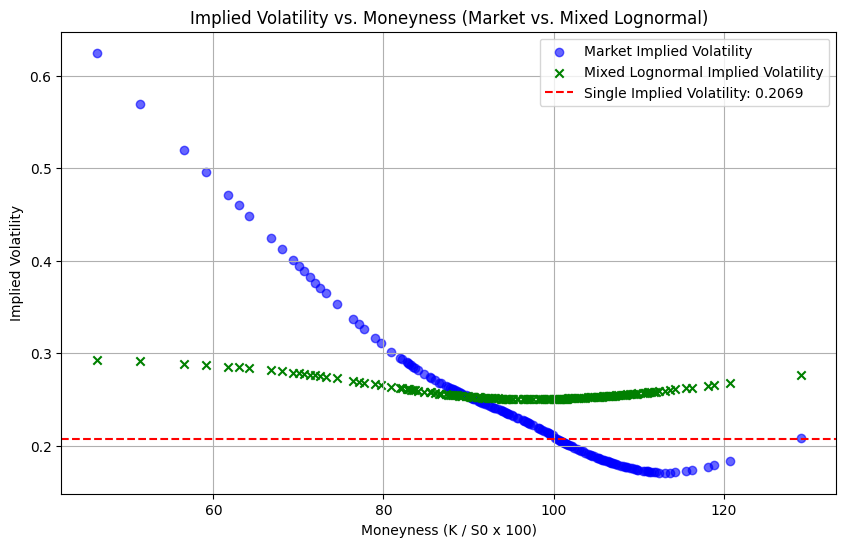

In [14]:
plt.figure(figsize=(10, 6))
plt.scatter(df["Strike"] / S0 * 100, df["ImpliedVol"], label="Market Implied Volatility", color="blue", alpha=0.6)
plt.scatter(df["Strike"] / S0 * 100, df["MixedLognormal_ImpliedVol"], label="Mixed Lognormal Implied Volatility", color="green", marker="x")
plt.axhline(y=sigma_M, color="red", linestyle="--", label=f"Single Implied Volatility: {sigma_M:.4f}")
plt.xlabel("Moneyness (K / S0 x 100)")
plt.ylabel("Implied Volatility")
plt.legend()
plt.title("Implied Volatility vs. Moneyness (Market vs. Mixed Lognormal)")
plt.grid()
plt.show()

